In [3]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial
import copy

from typing import List, Optional, Tuple
import hydra
from hydra import initialize, compose
import pytorch_lightning as pl
from omegaconf import DictConfig, OmegaConf

import sys
import os, shutil
import time

sys.path.append('..')

In [4]:
# Импорт пользовательских функций
from src.ScoreNetwork import ScoreNetwork
from src.DSBM_model_mod import DSBM, train_dsbm
from src.draw_plot import draw_plot

## Загрузка и задание параметров эксперимента

In [5]:
# Импорт параметров модели и данных

with initialize(version_base=None, config_path="../configurations"):
    
    cfg: DictConfig = compose(config_name="gaussian.yaml")

if cfg.get("seed"):
    pl.seed_everything(cfg.seed, workers=True)
print(cfg)

RESULT_DIR = '../results/' + cfg.paths.experiments_dir_name + '/'
if os.path.exists(RESULT_DIR):
    shutil.rmtree(RESULT_DIR)
os.makedirs(RESULT_DIR, exist_ok=True)

OmegaConf.save(cfg, RESULT_DIR + 'config.yaml')


# Параметры обучения
device = 'cpu'
dataset_size = 10000
test_dataset_size = 10000
lr = 1e-4
batch_size = 128

Seed set to 42


{'name': 'gaussian', 'seed': 42, 'a': 0.1, 'dim': 5, 'sigma': 1, 'num_steps': 20, 'net_name': 'mlp_large', 'activation_fn': 'torch.nn.SiLU', 'model_name': 'dsbm', 'first_coupling': 'ref', 'inner_iters': 100, 'outer_iters': 150, 'fb_sequence': ['b', 'f'], 'paths': {'experiments_dir_name': 'gaussian_temp_2'}}


## Генерация train-test датасетов (двух гауссиан)

In [6]:
# Генерация Гауссиан

a = cfg.a
dim = cfg.dim
initial_model = Normal(-a * torch.ones((dim, )), 1)
target_model = Normal(a * torch.ones((dim, )), 1)

x0 = initial_model.sample([dataset_size])
x1 = target_model.sample([dataset_size])
x_pairs = torch.stack([x0, x1], dim=1).to(device)

x0_test = initial_model.sample([test_dataset_size])
x1_test = target_model.sample([test_dataset_size])
x0_test = x0_test.to(device)
x1_test = x1_test.to(device)

# Сохраняем сформированные датасеты
torch.save({'x0': x0, 'x1': x1, 'x0_test': x0_test, 'x1_test': x1_test}, RESULT_DIR + "data.pt")
x_test_dict = {'f': x0_test, 'b': x1_test}

print('Гауссиана 0:')
print('mean: ', x0.mean().item())
print('var: ', x0.var().item())
print('cnt: ', x0.shape[0])
print('dim: ', x0.shape[1])

print('\nГауссиана 1:')
print('mean: ', x1.mean().item())
print('var: ', x1.var().item())
print('cnt: ', x1.shape[0])
print('dim: ', x1.shape[1])

Гауссиана 0:
mean:  -0.09754451364278793
var:  1.014742374420166
cnt:  10000
dim:  5

Гауссиана 1:
mean:  0.10176942497491837
var:  1.0090255737304688
cnt:  10000
dim:  5


## Инициализация модели

In [7]:
# Определение структуры модели

net_split = cfg.net_name.split("_")
if net_split[0] == "mlp":
    if net_split[1] == "small":
        net_fn = partial(ScoreNetwork, input_dim=dim+1, layer_widths=[128, 128, dim], activation_fn=hydra.utils.get_class(cfg.activation_fn)()) 
    else:
        net_fn = partial(ScoreNetwork, input_dim=dim+1, layer_widths=[256, 256, dim], activation_fn=hydra.utils.get_class(cfg.activation_fn)())  
else:
    raise NotImplementedError

num_steps = cfg.num_steps
sigma = cfg.sigma
inner_iters = cfg.inner_iters
outer_iters = cfg.outer_iters


if cfg.model_name == "dsbm":
    model = DSBM(net_fwd=net_fn().to(device), 
                 net_bwd=net_fn().to(device), 
                 num_steps=num_steps, sig=sigma, first_coupling=cfg.first_coupling)
    train_fn = train_dsbm
else:
    raise ValueError("Wrong model_name!")

model_list = []
time_list = []
optimal_result_dict = {'mean': x0_test.mean(0).mean(0).item(), 'var': x0_test.var(0).mean(0).item(), 'cov': (np.sqrt(5) - 1) / 2}
result_list = {k: [] for k in optimal_result_dict.keys()}

## Train-test loops

In [13]:
# Training loop

it = 1
lr = 1e-5
outer_iters = 50

with tqdm(total=outer_iters, desc="Training Loop iter") as pbar:
    while it <= outer_iters:
        for fb in cfg.fb_sequence:
          start_time = time.time()
    
          # train
          if len(model_list) == 0:
            prev_model = None
            first_it = True
          else:
            prev_model = model_list[-1]["model"].eval()
            first_it = False
              
          model, loss_curve = train_fn(model, x_pairs, batch_size, inner_iters, prev_model=prev_model, fb=fb, first_it=first_it, lr=lr)
          end_time = time.time()

          time_list.append(end_time-start_time)
          model_list.append({'fb': fb, 'model': copy.deepcopy(model).eval()})
          
            
          # test - только для модели b -> f
          # оцениваем на каждой 10 итерации
          if (it%10 == 0):
              
              i = len(model_list)
              traj = model.eval().sample_sde(zstart=x1_test, fb='b', N=cfg.num_steps)
            
              draw_plot(traj, z0=x0_test, z1=x1_test)
              plt.savefig(RESULT_DIR + f"iter_{i}-b.png")
              plt.close()
            
              result_list['mean'].append(traj[-1].mean(0).mean(0).item())
              result_list['var'].append(traj[-1].var(0).mean(0).item())
              result_list['cov'].append(torch.cov(torch.cat([traj[0], traj[-1]], dim=1).T)[dim:, :dim].diag().mean(0).item())
    
              for j, k in enumerate(result_list.keys()):
                  plt.plot(result_list[k], label=f"{cfg.model_name}-{cfg.net_name}")
                  plt.plot(np.arange(len(result_list[k])), optimal_result_dict[k] * np.ones(len(result_list[k])), label="optimal", linestyle="--")
                  plt.title(k.capitalize())
                  if j == 0:
                      plt.legend()
                  plt.savefig(RESULT_DIR +  f"convergence_{k}.png")
                  plt.close()
          else:
              pass
    
          it += 1
          pbar.update(1)
          if it > outer_iters:
            break

Training Loop iter: 100%|██████████████████████████████████████████████████████████████| 50/50 [00:51<00:00,  1.03s/it]


In [14]:
# Сохраняем результаты
# Сохраняем последнюю версию модели
torch.save(model_list[-1]['model'].state_dict(), RESULT_DIR + 'best_model.pt')

df_result = pd.DataFrame(result_list)
df_result.to_csv(RESULT_DIR + 'df_result.csv')
df_result.to_pickle(RESULT_DIR+ 'df_result.pkl')

df_time = pd.DataFrame(time_list)
df_time.to_csv(RESULT_DIR + 'df_time.csv')
df_time.to_pickle(RESULT_DIR+ 'df_time.pkl')

In [15]:
def print_res(target, fact, rnd, title):
    target = np.round(target,rnd)
    fact = np.round(fact,rnd)
    res = np.round(target - fact,rnd)
    res_percent = np.round(100*(target - fact)/target, 0)
    print('\n',title,':')
    print(f'target: {target}')
    print(f'fact: {fact}')
    print(f'res: {res}')
    print(f'res %: {res_percent}')

In [16]:
print(f'Среднее время выполнения операции: {np.round(df_time.mean(),0).item()} сек.')
print(f'Суммарное время обучения: {np.round(df_time.sum(),0).item()} сек. или {np.round(df_time.sum()/60,0).item()}  мин.')

print_res(x0_test.mean(0).mean(0).item(), df_result['mean'].iloc[-1], 4, 'mean')
print_res(x0_test.var(0).mean(0).item(), df_result['var'].iloc[-1], 4, 'var')
print_res((np.sqrt(5) - 1) / 2, df_result['cov'].iloc[-1], 4, 'cov')

Среднее время выполнения операции: 1.0 сек.
Суммарное время обучения: 91.0 сек. или 2.0  мин.

 mean :
target: -0.1025
fact: -0.094
res: -0.0085
res %: 8.0

 var :
target: 1.0076
fact: 1.0332
res: -0.0256
res %: -3.0

 cov :
target: 0.618
fact: 0.6112
res: 0.0068
res %: 1.0


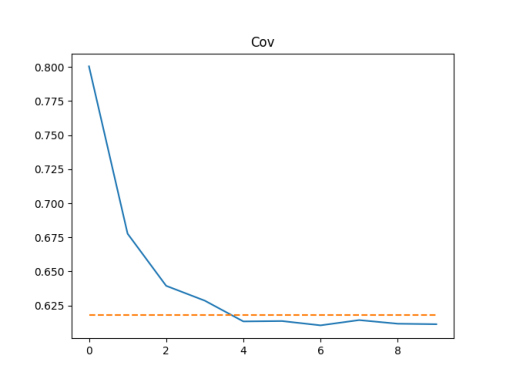

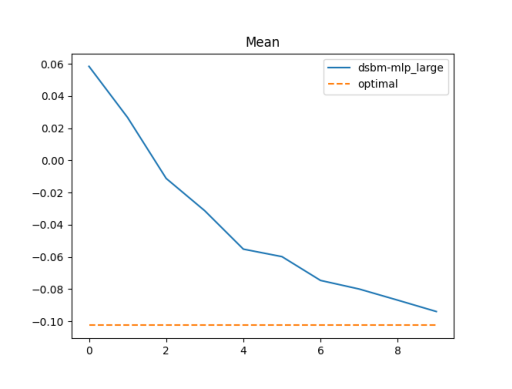

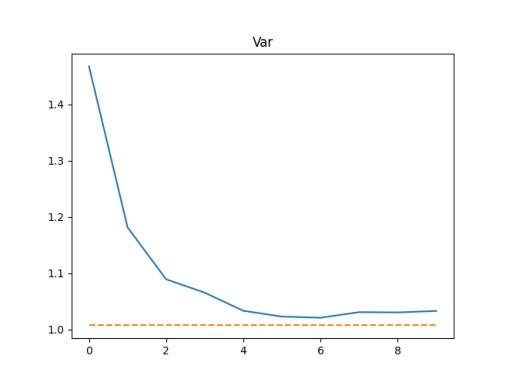

In [17]:
import matplotlib.image as mpimg

img = mpimg.imread(RESULT_DIR + 'convergence_cov.png')
plt.imshow(img)
plt.axis('off')
plt.show()

img = mpimg.imread(RESULT_DIR + 'convergence_mean.png')
plt.imshow(img)
plt.axis('off')
plt.show()

img = mpimg.imread(RESULT_DIR + 'convergence_var.png')
plt.imshow(img)
plt.axis('off')
plt.show()